There is an infleciton point in trip duration, around 2000 s

In [1]:
%run lyft_data.ipynb

In [17]:
# To plot:
#   1. Histogram of Trip Duration (Overall)
#   2. Trip Durations Normalized by Mean/Std - 100 most popular routes
#   3. Weekday Demands by Hour
#   4. Changes in Trip Demand by Year

In [18]:
agg_sf.columns

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'bike_share_for_all_trip', 'Year', 'Month', 'rental_access_method',
       'ride_id', 'rideable_type', 'member_casual'],
      dtype='object')

Text(0.5, 0, 'Route duration (sec)')

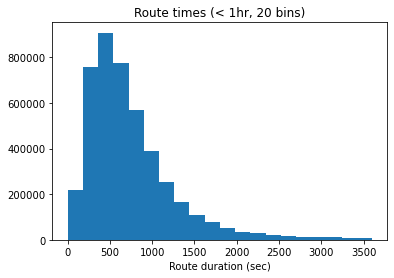

In [19]:
plt.hist(agg_sf[agg_sf["duration_sec"]<=3600]["duration_sec"], bins=20)
plt.title("Route times (< 1hr, 20 bins)")
plt.xlabel("Route duration (sec)")

In [191]:
route_counts = agg_sf.groupby(["start_station_longitude", "start_station_latitude", "end_station_longitude", "end_station_latitude"])["duration_sec"].count().reset_index().rename({"duration_sec": "count"},axis=1)
total_n_routes = route_counts.shape[0]
most_popular_routes = route_counts.sort_values("count", ascending=False).reset_index().drop("index", axis=1)
most_popular_routes = most_popular_routes[:1000]
most_popular_routes["High Demand Route"] = 1

In [192]:
agg_sf = agg_sf.merge(most_popular_routes, on=["start_station_longitude", "start_station_latitude","end_station_longitude", "end_station_latitude"], how="left")

In [193]:
route_mean = agg_sf[(agg_sf["High Demand Route"]) == 1 & (agg_sf["duration_sec"] < 3600)].groupby(["start_station_longitude", "start_station_latitude", "end_station_longitude", "end_station_latitude"])["duration_sec"].mean().reset_index().rename({"duration_sec": "mean duration"}, axis=1)
route_std  = agg_sf[(agg_sf["High Demand Route"]) == 1 & (agg_sf["duration_sec"] < 3600)].groupby(["start_station_longitude", "start_station_latitude", "end_station_longitude", "end_station_latitude"])["duration_sec"].std().reset_index().rename({"duration_sec": "std duration"}, axis=1)

In [194]:
station_z = agg_sf[(agg_sf["High Demand Route"] == 1) & (agg_sf["duration_sec"] < 3600)]
station_z = station_z.merge(route_mean, on=["start_station_longitude", "start_station_latitude","end_station_longitude", "end_station_latitude"], how="left").merge(route_std, on=["start_station_longitude", "start_station_latitude","end_station_longitude", "end_station_latitude"], how="left")
station_z["duration_z"] = station_z[["duration_sec", "mean duration", "std duration"]].apply (lambda x: (x["duration_sec"]-x["mean duration"])/x["std duration"], axis=1)

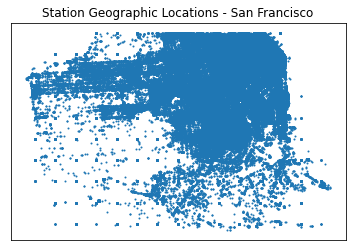

In [195]:
plt.scatter(agg_sf["start_station_longitude"], agg_sf["start_station_latitude"], s=1)
plt.title("Station Geographic Locations - San Francisco")
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

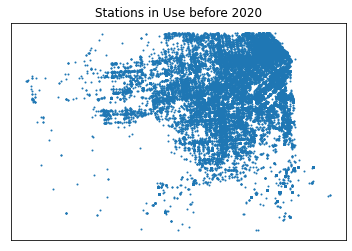

In [196]:
plt.scatter(agg_sf[agg_sf["start_time"] < pd.Timestamp(2020,1,1)]["start_station_longitude"], agg_sf[agg_sf["start_time"] < pd.Timestamp(2020,1,1)]["start_station_latitude"], s=1)
plt.title("Stations in Use before 2020")
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

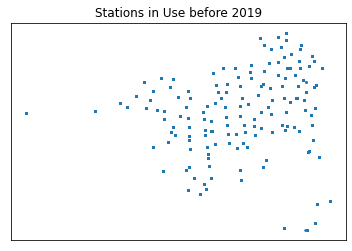

In [197]:
plt.scatter(agg_sf[agg_sf["start_time"] < pd.Timestamp(2019,1,1)]["start_station_longitude"], agg_sf[agg_sf["start_time"] < pd.Timestamp(2019,1,1)]["start_station_latitude"], s=1)
plt.title("Stations in Use before 2019")
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

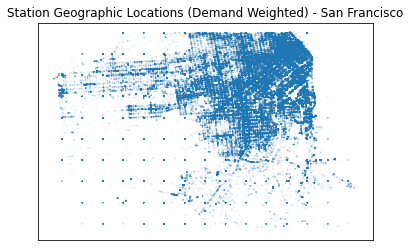

In [198]:
plt.scatter(route_counts["start_station_longitude"], route_counts["start_station_latitude"], s=(route_counts["count"]/1000))
plt.title("Station Geographic Locations (Demand Weighted) - San Francisco")
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

Text(0.5, 0, 'Normalized route duration (dimensionless)')

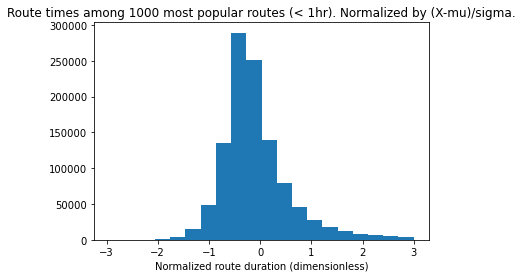

In [199]:
plt.hist(station_z[(station_z["duration_z"] < 3) & (station_z["duration_z"] > -3)]["duration_z"], bins=20)
plt.title("Route times among 1000 most popular routes (< 1hr). Normalized by (X-mu)/sigma.")
plt.xlabel("Normalized route duration (dimensionless)")

In [42]:
route_std

,start_station_longitude,start_station_latitude,end_station_longitude,end_station_latitude,duration_sec
0,-122.444293,37.773311,-122.444293,37.773311,5312.937341
1,-122.417385,37.776619,-122.411738,37.781074,1877.609031
2,-122.417385,37.776619,-122.408445,37.783899,1149.391389
3,-122.417385,37.776619,-122.404904,37.786375,1403.082810
4,-122.417385,37.776619,-122.400811,37.789625,1303.070259
...,...,...,...,...,...
95,-122.390833,37.767045,-122.393170,37.775880,475.499614
96,-122.390288,37.780526,-122.400811,37.789625,1385.170455
97,-122.390288,37.780526,-122.394430,37.794130,1149.847200
98,-122.390288,37.780526,-122.394203,37.795392,854.125006


([<matplotlib.axis.XTick at 0x7fb480032070>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

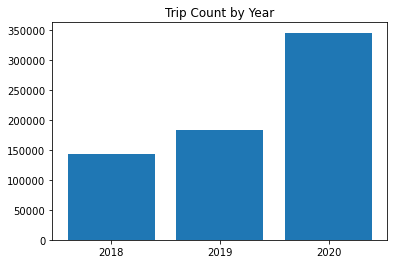

In [105]:
year_month_df = agg_sf.groupby(["Year","Month"])["duration_sec"].count().reset_index().rename({"duration_sec": "count"},axis=1).reset_index()
year_month_df["Year-Month"] = year_month_df.apply(lambda x: str(x["Year"]) + "-" + str(x["Month"]),axis=1)
plt.bar(year_month_df["Year"], year_month_df["count"])
plt.title("Trip Count by Year")
plt.xticks([2018,2019, 2020])

([<matplotlib.axis.XTick at 0x7fb4706384f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

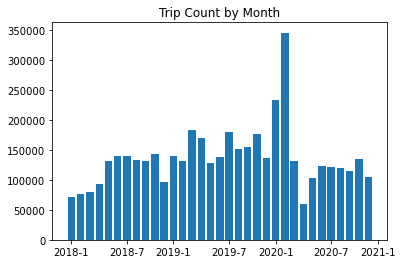

In [111]:
plt.bar(year_month_df["Year-Month"], year_month_df["count"])
plt.title("Trip Count by Month")
plt.xticks(["2018-1","2018-7","2019-1","2019-7","2020-1","2020-7","2021-1"])

In [69]:
agg_sf["day_hour"] = agg_sf["start_time"].apply(lambda x: x.hour)
agg_sf["is_weekend"] = agg_sf["start_time"].apply(lambda x: x.day_of_week in [5,6])
hour_df = agg_sf.groupby(["day_hour"])["duration_sec"].count().reset_index().rename({"duration_sec": "count"},axis=1).reset_index()
weekend_hour_df = agg_sf[agg_sf["is_weekend"]].groupby(["day_hour"])["duration_sec"].count().reset_index().rename({"duration_sec": "count"},axis=1).reset_index()
weekday_hour_df = agg_sf[~agg_sf["is_weekend"]].groupby(["day_hour"])["duration_sec"].count().reset_index().rename({"duration_sec": "count"},axis=1).reset_index()

Text(0.5, 1.0, 'Trip demand by hour (all days)')

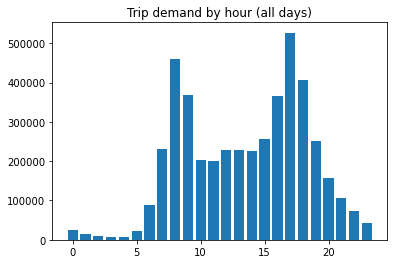

In [112]:
# overall plot
plt.bar(hour_df["day_hour"], hour_df["count"])
plt.title("Trip demand by hour (all days)")

Text(0.5, 1.0, 'Trip demand by hour (weekends only)')

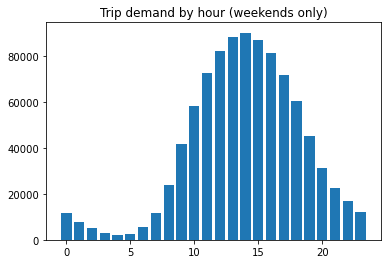

In [113]:
plt.bar(weekend_hour_df["day_hour"], weekend_hour_df["count"])
plt.title("Trip demand by hour (weekends only)")

Text(0.5, 1.0, 'Trip demand by hour (weekdays only)')

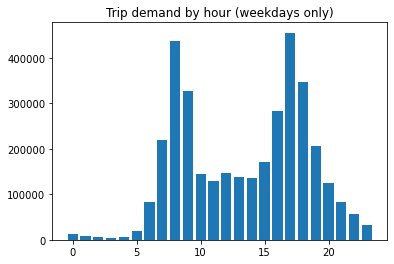

In [114]:
plt.bar(weekday_hour_df["day_hour"], weekday_hour_df["count"])
plt.title("Trip demand by hour (weekdays only)")

In [78]:
total_most_popular = most_popular_routes["count"].sum()
total_trips = agg_df.count()["duration_sec"]
most_popular_ratio = total_most_popular/total_trips
print(total_n_routes)
print(most_popular_ratio)

1077636
0.05384384682310877


In [79]:
100/1077636

9.279571209573548e-05

In [131]:
agg_sf.shape

(4512090, 24)

Text(0.5, 1.0, 'Station Geographic Locations')

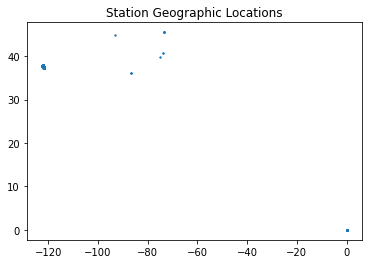

In [133]:
plt.scatter(agg_df["start_station_longitude"], agg_df["start_station_latitude"], s=1)
plt.title("Station Geographic Locations")

In [138]:
agg_sf["duration_sec"].describe()

count    4.512090e+06
mean     9.004711e+02
std      2.092186e+03
min      0.000000e+00
25%      3.900000e+02
50%      6.200000e+02
75%      9.630000e+02
max      8.639900e+04
Name: duration_sec, dtype: float64

In [202]:
agg_sf[agg_sf["duration_sec"]<3600]["duration_sec"].describe()

count    4.426568e+06
mean     7.405571e+02
std      5.289006e+02
min      0.000000e+00
25%      3.850000e+02
50%      6.100000e+02
75%      9.350000e+02
max      3.599000e+03
Name: duration_sec, dtype: float64